In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn import datasets
import matplotlib.pyplot as plt
from PIL import Image
import os

#### 1- Load and process the data

In [2]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 784  # 28x28
num_classes = 10
num_epochs = 5
batch_size = 128
learning_rate = 0.001

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='mnist_data/', 
                               train=True, 
                               transform=transform, 
                               download=True)

test_dataset = torchvision.datasets.MNIST(root='mnist_data/', 
                              train=False, 
                              transform=transform)

# Data loader
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

writer = SummaryWriter('runs/mnist1')  # Initialize TensorBoard

print(train_dataset)
print(test_dataset)

dataiter = iter(train_loader)
data = next(dataiter)
inputs, targets = data
print(inputs.shape, targets.shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
torch.Size([128, 1, 28, 28]) torch.Size([128])


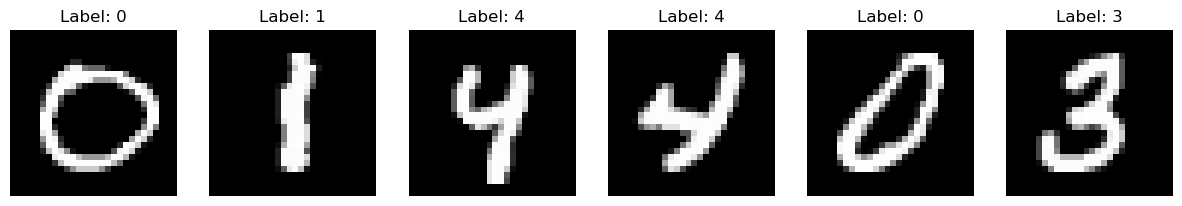

In [3]:
# Function to visualize samples
def visualize_samples(dataset, num_samples=6):
    # Get some random samples from the dataset
    indices = torch.randint(0, len(dataset), (num_samples,))
    samples = torch.utils.data.Subset(dataset, indices)
    
    # Plot the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i, (image, label) in enumerate(samples):
        image = image.squeeze().numpy()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Visualize samples from the training dataset
visualize_samples(train_dataset)

In [4]:
# Get some test images and write them to TensorBoard
examples = iter(test_loader)
example_data, example_targets = next(examples)

# Create a grid of images and log them
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)

# Close the writer
writer.close()

In [5]:
# After training, launch TensorBoard from the command line: tensorboard --logdir=runs
# This will start a local server. You can then open a web browser and go to http://localhost:6006 to view the TensorBoard dashboard.

#### 2- Build the model

In [6]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # no softmax at the end because the nn.CrossEntropyLoss() applies the softmax
        return out

model = NeuralNet(input_size, num_classes).to(device)

writer.add_graph(model, example_data.reshape(-1, 28*28).to(device))
writer.close()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### 3- Train the model

In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0.0
        for i, (images, labels) in enumerate(train_loader):  
            images = images.reshape(-1, 28*28).to(device)   # (128, 784)
            labels = labels.to(device)                      # (128,)
            
            # Forward pass
            outputs = model(images)                         # (128, 10)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 99:  # log every 100 mini-batches
                writer.add_scalar('training loss', running_loss / 100, epoch * total_step + i)
                running_accuracy = running_correct / 100 / predicted.size(0)
                writer.add_scalar('training accuracy', running_accuracy, epoch * len(train_loader) + i)
                running_loss = 0.0
                running_correct = 0.0
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    writer.close()

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch [1/5], Step [469/469], Loss: 0.3143
Epoch [2/5], Step [469/469], Loss: 0.1376
Epoch [3/5], Step [469/469], Loss: 0.1077
Epoch [4/5], Step [469/469], Loss: 0.0733
Epoch [5/5], Step [469/469], Loss: 0.0246


#### 4- Evaluate the model

In [6]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()  # sets the model to evaluation mode (no dropout, batchnorm, etc)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')

# Evaluate the model
evaluate_model(model, test_loader, device)

Accuracy of the model on the 10000 test images: 97.28%


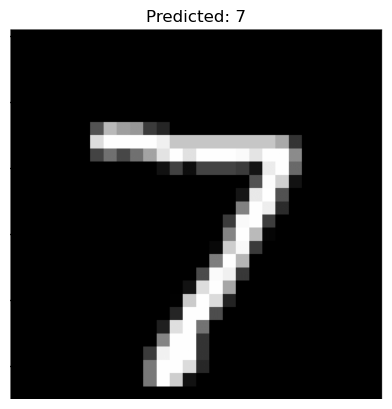

In [7]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Class names for CIFAR-10 dataset
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Ask the user to upload an image
root = Tk()
#root.withdraw()  # Hide the root window
initial_dir = os.getcwd()
filename = askopenfilename(initialdir=initial_dir, title='Select an image file', filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.webp")])
root.destroy()  # Close the Tkinter window

# Ensure to match these with the normalization parameters used during training
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to match the input size of the network
    transforms.Grayscale(),       # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# Load and preprocess the image
image = Image.open(filename).convert('RGB')  # Ensure image is RGB
transformed_image = transform(image)
transformed_image = transformed_image.unsqueeze(0).to(device)     # Add batch dimension and move to device
transformed_image = transformed_image.reshape(-1, 28*28)

model.eval()
with torch.no_grad():
    output = model(transformed_image)
    _, predicted = torch.max(output.data, 1)

predicted_label = class_names[predicted.item()]
    
# Display the image and the classification result
plt.imshow(image, cmap='gray')
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()

# Callbacks

In [8]:
def save_checkpoint(model, epoch, path='checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")

In [9]:
def early_stopping(loss, accuracy, loss_threshold, acc_threshold, patience, stop_counter):
    if loss < loss_threshold or accuracy > acc_threshold:
        stop_counter += 1
        if stop_counter >= patience:
            print("Early stopping triggered")
            return True, stop_counter
    else:
        stop_counter = 0
    return False, stop_counter

In [10]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # no softmax at the end because the nn.CrossEntropyLoss() applies the softmax
        return out

model = NeuralNet(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Training function with callbacks
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    stop_counter = 0
    patience = 3
    loss_threshold = 0.06
    acc_threshold = 0.98  # Example threshold for accuracy
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(train_loader)
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Callbacks
        #save_checkpoint(model, epoch)
        stop, stop_counter = early_stopping(avg_loss, accuracy, loss_threshold, acc_threshold, patience, stop_counter)
        if stop:
            break

train_model(model, train_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch [1/10], Loss: 0.3018, Accuracy: 0.9134
Epoch [2/10], Loss: 0.1287, Accuracy: 0.9618
Epoch [3/10], Loss: 0.0877, Accuracy: 0.9740
Epoch [4/10], Loss: 0.0671, Accuracy: 0.9795
Epoch [5/10], Loss: 0.0527, Accuracy: 0.9842
Epoch [6/10], Loss: 0.0431, Accuracy: 0.9873
Epoch [7/10], Loss: 0.0345, Accuracy: 0.9894
Early stopping triggered
